## <center> 图卷积网络-GCN

### 一、图上的谱卷积

定义图上的节点信号$x \in R^N$，图上有傅立叶域的卷积滤波器$g_{\theta}(\lambda)$，其中$\lambda$是图的拉普拉斯特征值。图上的滤波操作或谱卷积定义为：
$$g_{\theta}(\lambda) * x = Ug_{\theta}(\lambda)U^Tx$$
在基础概念中已经介绍$U^Tx$为图节点信号的傅立叶变换，可以由对称归一化之后的图拉普拉斯矩阵对角化之后得到：$L_{\mathrm{sym}} = U\Lambda U^T$，对称归一化的图拉普拉斯矩阵可以由图拉普拉斯矩阵得到：
$$
\begin{aligned}
L_{\mathrm{sym}} &= D^{-1/2}LD^{-1/2} \\
&= D^{-1/2}(D-A)D^{-1/2} \\
&= I - D^{-1/2}AD^{-1/2}
\end{aligned}
$$


Orthogonal : True
Original Signal: [1 2 3 4 5]
Signal after Convolution: [1.71273818 2.56750259 2.83109972 3.98980303 3.31929821]


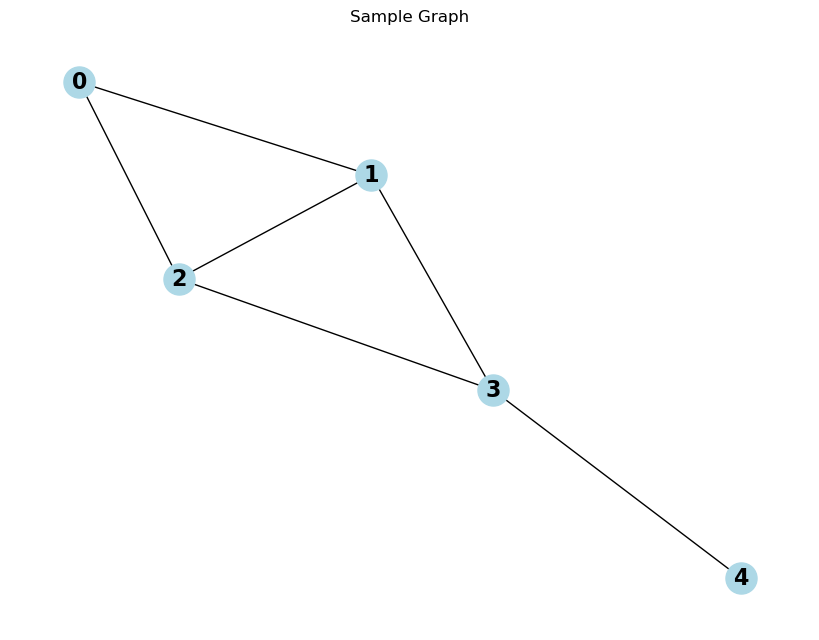

In [1]:
import numpy as np
import networkx as nx
from scipy import integrate
import matplotlib.pyplot as plt

def create_graph():
    G = nx.Graph()
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)])
    return G

def compute_laplacian(G):
    A = nx.adjacency_matrix(G).toarray()
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L_sym = np.dot(np.dot(D_inv_sqrt, L), D_inv_sqrt)
    return L_sym

def spectral_conv(x, g_theta, U):
    return np.dot(U, g_theta * np.dot(U.T, x))

def verify_orthogonality(U):
    n = U.shape[0]
    product = np.dot(U, U.T)
    is_orthogonal = np.allclose(product, np.eye(n), atol=1e-6)
    return is_orthogonal


# create a sample graph
G = create_graph()

# calculate the Laplacian matrix
L_sym = compute_laplacian(G)

# calculate the eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(L_sym)

# verify if the eigenvectors are orthogonal
is_orthogonal = verify_orthogonality(eigenvectors)
print(f"Orthogonal : {is_orthogonal}")

# define a simple filter function
x = np.array([1, 2, 3, 4, 5])

# define the filter function
g_theta = np.exp(-eigenvalues)

# graph convolution
result = spectral_conv(x, g_theta, eigenvectors)

print("Original Signal:", x)
print("Signal after Convolution:", result)

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
plt.title("Sample Graph")
plt.show()

### 二、切比雪夫多项式截断

从图上的滤波操作$g_{\theta}(\lambda) * x = Ug_{\theta}(\lambda)U^Tx$可以看出，由于涉及到$n\times n$矩阵和$n \times 1$向量的乘法操作，图卷积的计算复杂度为$O(n^2)$。为了减少计算复杂度，我们引入切比雪夫多项式。

考虑如下方程：
$$(1 - x^2) \frac{d^2 y}{dx^2} - x \frac{dy}{dx} + n^2 y = 0 $$
其有解为$T_n(x) = \cos(n \arccos(x))$，即切比雪夫多项式。该方程作为施图姆-刘维尔方程的一种特殊形式，其解切比雪夫多项式满足一系列性质：

1.	正交性：
切比雪夫多项式在 $[-1, 1]$ 区间上相对于权重函数 $w(x) = \frac{1}{\sqrt{1-x^2}}$ 是正交的，即：
 $$\int_{-1}^{1} \frac{T_m(x) T_n(x)}{\sqrt{1 - x^2}} \, dx = \begin{cases}
0 & \text{if } m \ne n \\
\frac{\pi}{2} & \text{if } m = n \ne 0 \\
\pi & \text{if } m = n = 0
\end{cases} $$

2.  完备性：任何函数都可以写为切比雪夫多项式的线性组合。（类比泰勒展开）
    
3.	极值和零点：

	•	$T_n(x)$ 有 $n$ 个零点，这些零点位于 $[-1, 1]$ 区间内，并且是均匀分布的。

	•	$T_n(x)$ 在 $[-1, 1]$ 区间内的极值为 $\pm 1$。

4.	最小范数性质：在所有最高次项系数为 $1$ 的 $n$ 次多项式中，切比雪夫多项式在 $[-1, 1]$ 区间内的最大绝对值最小。

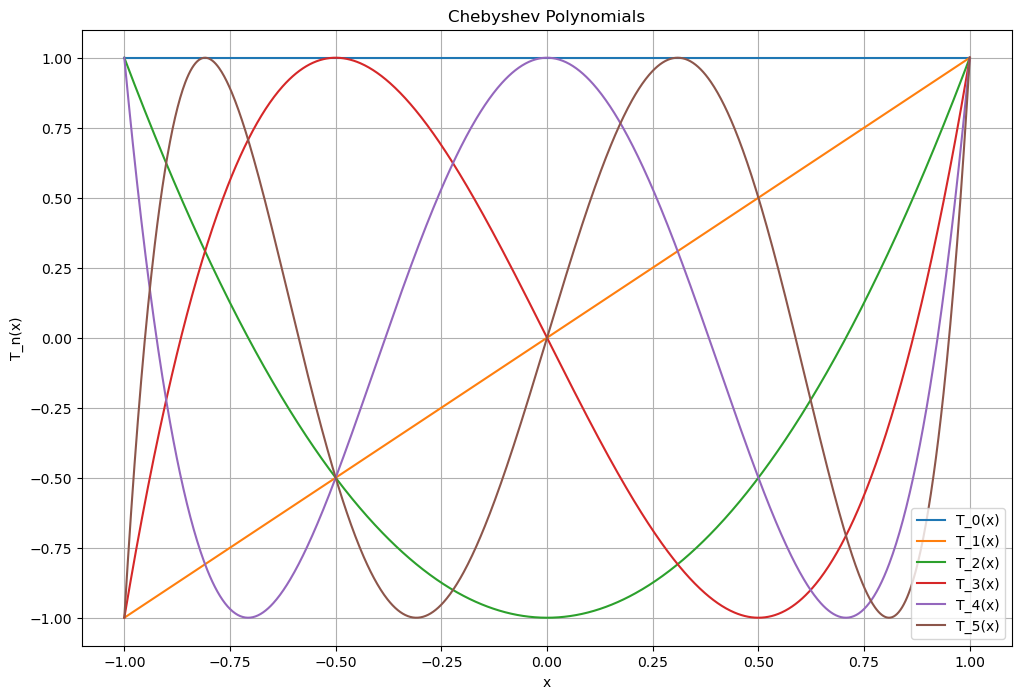

Integral for T_2 and T_3: -0.000000
Expected value: 0.000000
Difference: 3.002657e-17
Integral for T_2 and T_2: 1.570796
Expected value: 1.570796
Difference: 1.443290e-14
Zeros: [ 9.51056516e-01  5.87785252e-01  6.12323400e-17 -5.87785252e-01
 -9.51056516e-01]
Extrema: [ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.        ]


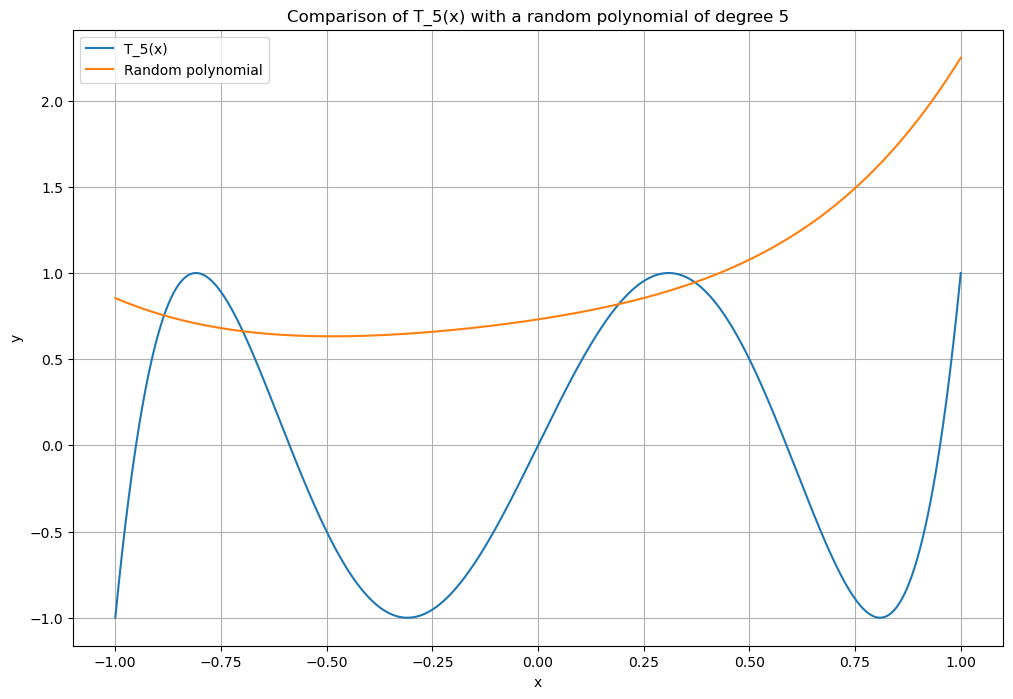

Max absolute value of T_5(x): 1.0
Max absolute value of random polynomial: 2.2491292820346525


In [2]:
def chebyshev_polynomial(n, x):
    """
    Compute the Chebyshev polynomial of the first kind T_n(x).
    """
    return np.cos(n * np.arccos(x))

def chebyshev_weight(x):
    """
    Compute the weight function for Chebyshev polynomials.
    """
    return 1 / np.sqrt(1 - x**2)

def plot_chebyshev_polynomials(max_degree):
    """
    Plot Chebyshev polynomials up to the specified degree.
    """
    x = np.linspace(-1, 1, 1000)
    plt.figure(figsize=(12, 8))
    for n in range(max_degree + 1):
        y = chebyshev_polynomial(n, x)
        plt.plot(x, y, label=f'T_{n}(x)')
    plt.title('Chebyshev Polynomials')
    plt.xlabel('x')
    plt.ylabel('T_n(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

def verify_orthogonality(m, n):
    """
    Verify the orthogonality of Chebyshev polynomials.
    """
    def integrand(x):
        return chebyshev_polynomial(m, x) * chebyshev_polynomial(n, x) * chebyshev_weight(x)
    
    result, _ = integrate.quad(integrand, -1, 1)
    
    if m != n:
        expected = 0
    elif m == n != 0:
        expected = np.pi / 2
    else:  # m == n == 0
        expected = np.pi
    
    print(f"Integral for T_{m} and T_{n}: {result:.6f}")
    print(f"Expected value: {expected:.6f}")
    print(f"Difference: {abs(result - expected):.6e}")

def find_zeros_and_extrema(n):
    """
    Find zeros and extrema of the n-th Chebyshev polynomial.
    """
    # Zeros
    k = np.arange(1, n + 1)
    zeros = np.cos((2*k - 1) * np.pi / (2*n))
    
    # Extrema
    k = np.arange(n + 1)
    extrema = np.cos(k * np.pi / n)
    
    return zeros, extrema

def demonstrate_min_norm_property(n):
    """
    Demonstrate the minimum norm property of Chebyshev polynomials.
    """
    x = np.linspace(-1, 1, 1000)
    cheb = chebyshev_polynomial(n, x)
    
    # Create a polynomial with the same degree and leading coefficient
    coeffs = np.random.rand(n)
    coeffs = np.append(coeffs, 2**(-n+1))  # Set the leading coefficient to match Chebyshev
    poly = np.polynomial.polynomial.Polynomial(coeffs)
    
    plt.figure(figsize=(12, 8))
    plt.plot(x, cheb, label=f'T_{n}(x)')
    plt.plot(x, poly(x), label='Random polynomial')
    plt.title(f'Comparison of T_{n}(x) with a random polynomial of degree {n}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Max absolute value of T_{n}(x): {np.max(np.abs(cheb))}")
    print(f"Max absolute value of random polynomial: {np.max(np.abs(poly(x)))}")

# Example usage (to be run in a Jupyter notebook):
plot_chebyshev_polynomials(5)
verify_orthogonality(2, 3)
verify_orthogonality(2, 2)
zeros, extrema = find_zeros_and_extrema(5)
print("Zeros:", zeros)
print("Extrema:", extrema)
demonstrate_min_norm_property(5)

### 三、图卷积

基于这些性质，我们可以通过切比雪夫多项式来近似表示滤波器$g_{\theta}(\lambda)$：
$$g_{\theta}(\Lambda) = \sum_{k=0}^{K}\theta_kT_k(\widetilde{\Lambda}),~\widetilde{\Lambda}=\frac{2}{\lambda_{\mathrm{max}}}\Lambda - I$$
这里$\lambda_{\mathrm{max}}$是$L_{\mathrm{sym}}$的最大特征值，通过$\widetilde{\Lambda}=\frac{2}{\lambda_{\mathrm{max}}}\Lambda - I$这一变量代换的操作，我们成功的在不失一般性的情况下限制了自变量$\widetilde{\Lambda}$的范围在$[-1 , 1]$之间，参考切比雪夫多项式的性质，这有利于保证神经网络计算过程中的数值稳定性。

取$K = 1$作一阶截断（当阶数高了以后容易产生过拟合问题），设置$\lambda_{\mathrm{max}} = 2$，将截断后的滤波器代入图卷积，有：
$$
\begin{aligned}
g_{\theta}(\Lambda) * x &= U \big( \sum_{k=0}^{1} \theta_{k} T_{k}(\widetilde{\Lambda}) \big) U^T x \\
&= U \big( \sum_{k=0}^{1} \theta_{k} T_{k}(\Lambda - I) \big) U^T x \\
&= U \theta_0 U^T x + U \theta_1 (\Lambda - I) U^T x \\
&= \theta_0 x + \theta_1 U \Lambda U^T x - \theta_1 U I U^T x \\
&= \theta_0 x + \theta_1(L_{\mathrm{sym}} - I) x \\
&= \theta_0 x - \theta_1 D^{-1/2}AD^{-1/2} x
\end{aligned}
$$
进一步减少参数数量防止过拟合，另$\theta_0 + \theta_1 = 0$，则上式最终变为：
$$g_{\theta} * x \approx \theta(I + D^{-1/2}AD^{-1/2})x$$
出于数值稳定性的考量，以及图上的信号在节点间传播的情况，考虑对邻接矩阵和度矩阵加入自环：
$\widetilde{D} = D + I, \widetilde{A} = A + I$,则我们最终得到了图卷积的最终形式：
$$H = \widetilde{D}^{-1/2}\widetilde{A}\widetilde{D}^{-1/2}XW$$
其中$X \in R^{N\times C}$代表$N$个节点每个节点有$C$个特征的输入，$W \in R^{C\times F}$代表参数矩阵，即将上述所说的单节点参数向量$\theta$聚合为矩阵。$H \in R^{N \times F}$即初始信号$X$被滤波器卷积后所得卷积信号。

Input features shape: (5, 3)
Weight matrix shape: (3, 2)
Output features shape: (5, 2)

Input features:
[[-2.01195941  2.52248659 -0.50182464]
 [-2.18507437  0.94316472  0.45808128]
 [-0.66305747  0.56590414  0.16886953]
 [-0.93793584 -0.84171848 -0.1110403 ]
 [-0.56804858  0.07288786 -0.63165067]]

Output features after graph convolution:
[[-0.6009348  -2.42682672]
 [-0.70000783 -2.17853063]
 [-0.70000783 -2.17853063]
 [-0.62407909 -1.31016587]
 [-0.40316624 -0.60237274]]


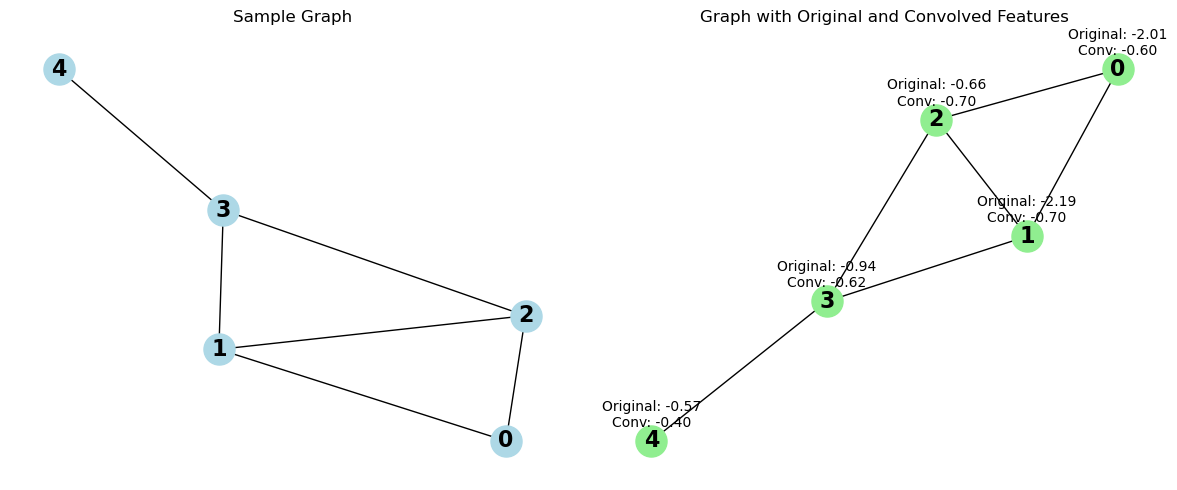

In [3]:
def compute_normalized_adjacency(G):
    """Compute the normalized adjacency matrix with self-loops."""
    A = nx.adjacency_matrix(G).toarray()
    I = np.eye(G.number_of_nodes())
    A_tilde = A + I
    D_tilde = np.diag(np.sum(A_tilde, axis=1))
    D_tilde_inv_sqrt = np.linalg.inv(np.sqrt(D_tilde))
    return np.dot(np.dot(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt)

def graph_conv_layer(X, W, A_norm):
    """Perform graph convolution operation."""
    return np.dot(np.dot(A_norm, X), W)

# calculate the normalized adjacency matrix
A_norm = compute_normalized_adjacency(G)

# create a sample feature matrix (5 nodes, 3 input features)
X = np.random.randn(5, 3)

# create a sample weight matrix (3 input features, 2 output features)
W = np.random.randn(3, 2)

# graph convolution
H = graph_conv_layer(X, W, A_norm)

print("Input features shape:", X.shape)
print("Weight matrix shape:", W.shape)
print("Output features shape:", H.shape)
print("\nInput features:")
print(X)
print("\nOutput features after graph convolution:")
print(H)

# plot the graph with original and convolved features
plt.figure(figsize=(12, 5))

plt.subplot(121)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
plt.title("Sample Graph")

plt.subplot(122)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=16, font_weight='bold')
for i, (x, y) in pos.items():
    plt.text(x, y+0.1, f'Original: {X[i,0]:.2f}\nConv: {H[i,0]:.2f}', ha='center', va='center')
plt.title("Graph with Original and Convolved Features")

plt.tight_layout()
plt.show()

### 四、图卷积网络(GCN)架构
根据上述铺垫，可以写出图卷积网络的基本架构：
$$H^{k+1} = \sigma(\widetilde{D}^{-1/2}\widetilde{A}\widetilde{D}^{-1/2}H^{k}W^{k})$$
其中$H^{k} \in R^{N \times F}$表示第$k$层的节点表征，$W^{k} \in R^{F \times F'}$则代表了节点表征从$k$到$k+1$层的过渡。